#1. Baseline model

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, mean_absolute_error, f1_score
from sklearn.preprocessing import StandardScaler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
np.random.seed(42)

In [ ]:
heart_attack_df = pd.read_csv("heart.csv")
heart_attack_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
heart_attack_df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [ ]:
x = heart_attack_df.drop(columns="output")
y = heart_attack_df["output"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2021)

In [ ]:
scaler= StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [ ]:
# List of models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbosity=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Dictionary to store evaluation metrics
metrics_dict = {}

# Loop through models, train and evaluate
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    mse = mean_squared_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics_dict[model_name] = {
        "MSE": mse,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

metrics_df = pd.DataFrame(metrics_dict).T

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:45:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
print(metrics_df)

                          MSE  Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.196721  0.803279   0.846154  0.846154  0.846154
Random Forest        0.213115  0.786885   0.825000  0.846154  0.835443
SVC                  0.163934  0.836066   0.871795  0.871795  0.871795
KNN                  0.163934  0.836066   0.871795  0.871795  0.871795
Gradient Boosting    0.196721  0.803279   0.813953  0.897436  0.853659
XGBoost              0.213115  0.786885   0.825000  0.846154  0.835443
LightGBM             0.196721  0.803279   0.829268  0.871795  0.850000
CatBoost             0.196721  0.803279   0.829268  0.871795  0.850000


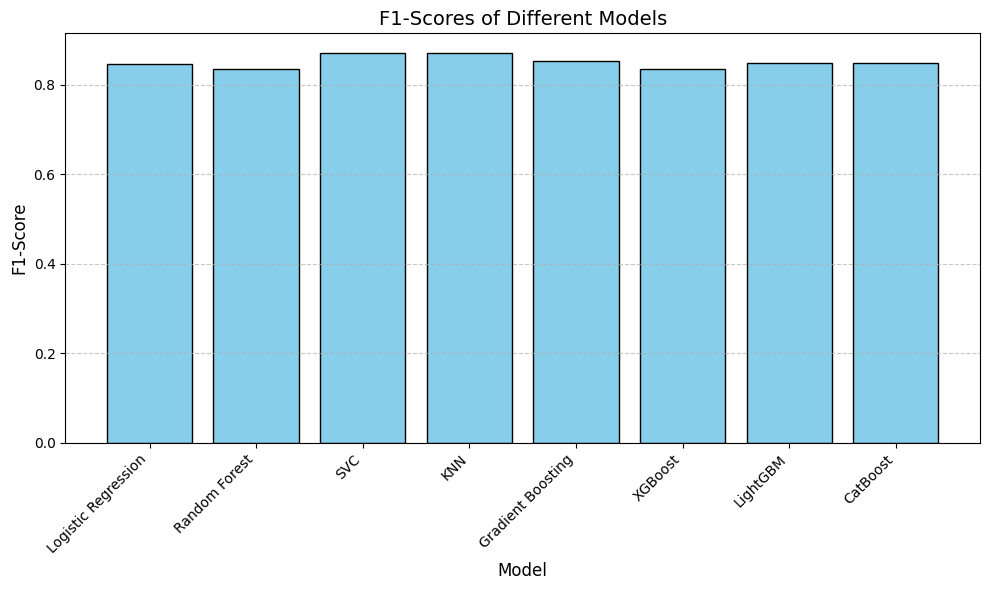

In [ ]:
f1_scores = metrics_df['F1-Score']
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.index, f1_scores, color='skyblue', edgecolor='black')
plt.title('F1-Scores of Different Models', fontsize=14)
plt.ylabel('F1-Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

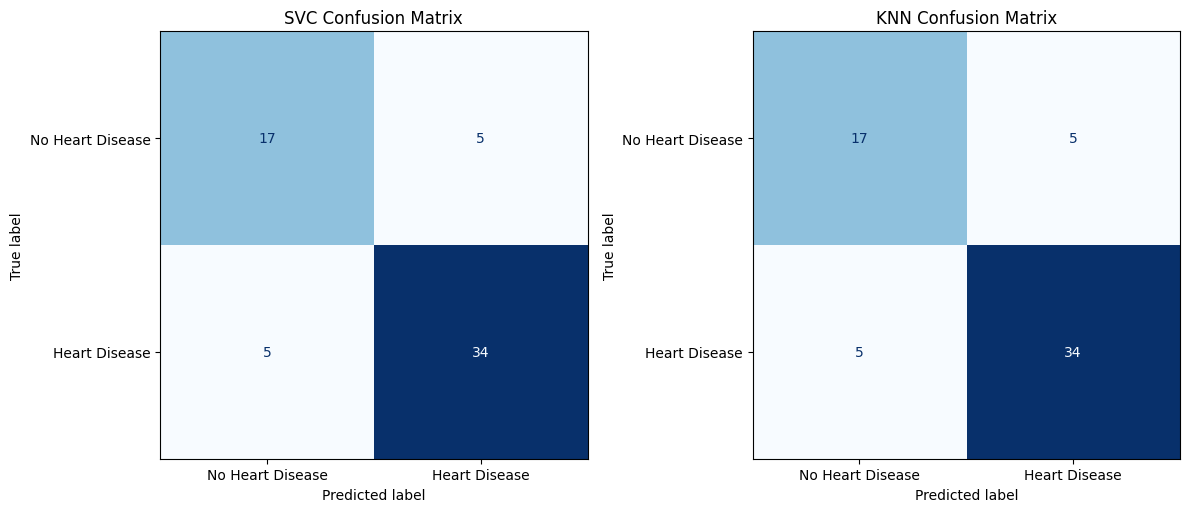

In [ ]:
svc = SVC(probability=True, random_state=42)
knn = KNeighborsClassifier()

# Train the models
svc.fit(x_train, y_train)
knn.fit(x_train, y_train)

# Make predictions
svc_preds = svc.predict(x_test)
knn_preds = knn.predict(x_test)

# Confusion Matrices
svc_cm = confusion_matrix(y_test, svc_preds)
knn_cm = confusion_matrix(y_test, knn_preds)

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# SVC Confusion Matrix
ConfusionMatrixDisplay(svc_cm, display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('SVC Confusion Matrix')

# KNN Confusion Matrix
ConfusionMatrixDisplay(knn_cm, display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('KNN Confusion Matrix')

plt.tight_layout()
plt.show()

#2. Hyperopt

We select SVC and KNN to further analyse them, since they had the best F1 scores.

In [ ]:
def objective_knn(params):
  knn = KNeighborsClassifier()
  knn.fit(x_train, y_train)
  y_pred = knn.predict(x_test)
  mse = mean_squared_error(y_test, y_pred)
  return {'loss': mse, 'status': STATUS_OK}

def objective_svc(params):
  svc = SVC()
  svc.fit(x_train, y_train)
  y_pred = svc.predict(x_test)
  mse = mean_squared_error(y_test, y_pred)
  return {'loss': mse, 'status': STATUS_OK}

In [ ]:
# Define search space for RandomForest model
search_space_knn = {
    'n_neighbors': scope.int(hp.quniform('n_neighbors', 2, 50, 1)),  # Number of neighbors (at least 2)
    'weights': hp.choice('weights', ['uniform', 'distance']),  # Weighting strategy
    'p': hp.choice('p', [1, 2]),  # Distance metric: 1 for Manhattan, 2 for Euclidean
    'metric': hp.choice('metric', ['minkowski', 'euclidean', 'manhattan']),  # Distance metric type
    'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])  # Algorithm for nearest neighbors search
}

search_space_svc = {
    'C': hp.loguniform('C', -4, 4),  # Regularization parameter (log scale for wide range)
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),  # Kernel type
    'degree': scope.int(hp.quniform('degree', 2, 5, 1)),  # Degree of polynomial kernel (used if kernel='poly')
    'gamma': hp.choice('gamma', ['scale', 'auto']),  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'random_state': 42  # Fixed for reproducibility
}

In [ ]:
knn_trials = Trials()
svc_trials = Trials()

In [ ]:
best_knn = fmin(fn=objective_knn,
            space=search_space_knn,
            algo=tpe.suggest,
            max_evals = 200,
            trials = knn_trials,
            rstate = np.random.default_rng(42))
best_svc = fmin(fn=objective_svc,
            space=search_space_svc,
            algo=tpe.suggest,
            max_evals = 200,
            trials = svc_trials,
            rstate = np.random.default_rng(42))
print("Best hyperparameters KNN: ", best_knn)
print("Best hyperparameters SVC: ", best_svc)

100%|██████████| 200/200 [00:03<00:00, 65.56trial/s, best loss: 0.16393442622950818]
Best hyperparameters KNN:  {'algorithm': 3, 'metric': 1, 'n_neighbors': 32.0, 'p': 1, 'weights': 0}
Best hyperparameters SVC:  {'C': 21.572362980125604, 'degree': 4.0, 'gamma': 1, 'kernel': 0}


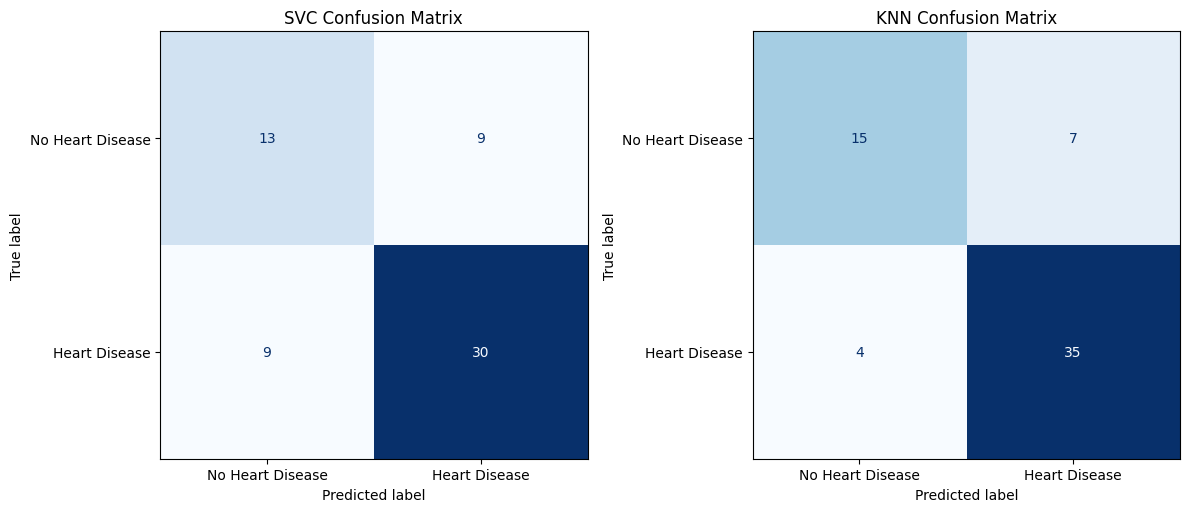

In [ ]:
svc = SVC(probability=True, random_state=42, C=21.572362980125604, degree=4, gamma='auto', kernel='poly')
knn = KNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=32, p=2, weights='uniform')

# Train the models
svc.fit(x_train, y_train)
knn.fit(x_train, y_train)

# Make predictions
svc_preds = svc.predict(x_test)
knn_preds = knn.predict(x_test)

# Confusion Matrices
svc_cm = confusion_matrix(y_test, svc_preds)
knn_cm = confusion_matrix(y_test, knn_preds)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(svc_cm, display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('SVC Confusion Matrix')
ConfusionMatrixDisplay(knn_cm, display_labels=['No Heart Disease', 'Heart Disease']).plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('KNN Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
mse_svc = mean_squared_error(y_test, svc_preds)
mse_knn = mean_squared_error(y_test, knn_preds)
accuracy_svc = accuracy_score(y_test, svc_preds)
accuracy_knn = accuracy_score(y_test, knn_preds)
f1_svc = f1_score(y_test, svc_preds)
f1_knn = f1_score(y_test, knn_preds)

print(f"Scores for best SVC model: MSE:{round(mse_svc, 3)}, Accuracy:{round(accuracy_svc, 3)}, F1:{round(f1_svc, 3)}")
print(f"Scores for best KNN model: MSE:{round(mse_knn, 3)}, Accuracy:{round(accuracy_knn, 3)}, F1:{round(f1_knn, 3)}")

Scores for best SVC model: MSE:0.295, Accuracy:0.705, F1:0.769
Scores for best KNN model: MSE:0.18, Accuracy:0.82, F1:0.864
